In this notebook we present how we computed the predictions of our 10 averaged level 5 models. All the decision made in this notebook are based on the result obtained in the Experiments notebook we provide.

In [ ]:
from google.colab import drive
import os
import numpy as np
from skimage import io
import re
import cv2
from tqdm.notebook import tqdm

drive.mount("/content/gdrive", force_remount=True)
drive_path = "/content/gdrive/MyDrive/Project-KLM/" 
os.chdir(drive_path)

Mounted at /content/gdrive


In [ ]:
from libs.models import *
from libs.ImageGen import *
from libs.sliding_window import *
from libs.post_process import *
from libs.threshold import *
from libs.averaging import *
from libs.submission import *
from libs.augmentation import *

In [ ]:
#Parameters to load the data
input_dir = "training/images"
target_dir = "training/groundtruth/"
img_size = (400, 400) #Don't edit size
batch_size = 100
seed = 10
NUMBER_OF_MODELS = 10

aug_gen_args = {'validation_split' : 0.2}  #Only param is validation 80/20 split

#Load the data (80 training images, 20 validation images)
grayscale_x = False
imgen = ImageGenerator(input_dir, target_dir, aug_gen_args, seed, img_size, batch_size, grayscale_x, force_batch_size=False)
train_gen, valid_gen = imgen.get_normal_generator()
train_x, train_y = next(train_gen)
valid_x, valid_y = next(valid_gen)

Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


# Augmenting validation set

In [ ]:
# set seed for reprodubility and retrieve (new) data to serve as validation
np.random.seed(seed)
new_x, new_y = apply_augments(valid_x), apply_augments(valid_y)

# validation set on pred_n = 96 images out of the 240 which result from the flips and rotations
pred_n = 96
selected_indices = np.random.randint(0,len(new_x),pred_n)
new_x, new_y = new_x[selected_indices], new_y[selected_indices]

cropper = iaa.Sequential([iaa.size.CropToFixedSize(width=256,height=256,random_state=1)])
cropped_x = cropper.augment_images(new_x)

cropper = iaa.Sequential([iaa.size.CropToFixedSize(width=256,height=256,random_state=1)])
cropped_y = cropper.augment_images(new_y)

# create batches from selected validation set
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

batched_x = [np.stack(x) for x in chunks(cropped_x,16)]
batched_y = [np.stack(y) for y in chunks(cropped_y,16)]

valid_cropped = (batched_x,batched_y)

print("Validation batches are of shape:")
batched_x[0].shape, batched_y[0].shape

Validation batches are of shape:


((16, 256, 256, 3), (16, 256, 256, 1))

# Data Augmentation Parameters

In [ ]:
aug_gen_args = {
    'rotation_range' : 90,
    'width_shift_range' : 0.2,
    'height_shift_range' : 0.2,
    'horizontal_flip' : False,
    'vertical_flip' : False,
}

# Model computation


## Train Level 5 Models

As we already provide 10 level 5 models, this cell it is not required to run this cell.

In [ ]:
from multiprocessing import Process,Value
from IPython.display import clear_output
from tensorflow.keras.metrics import Recall, Precision
from keras import backend as K
import sys

EPOCHS = 15
STEPS_PER_EPOCH = 250

def evaluate_models(i,stdout) :
  sys.stdout = stdout
  #We use a different seed for each model
  seed = random.randint(0,2**32 -1 )
  datagen = ImageDataGenerator(**aug_gen_args)
  train_image_gen = datagen.flow(train_x,seed=seed,batch_size=16)
  train_mask_gen  = datagen.flow(train_y,seed=seed,batch_size=16)
  train_gen = zip(train_image_gen, train_mask_gen)
  train_gen = crop_generator(train_gen, 256,seed)
  
  print('Creating model')
  callbacks = []
  callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3,patience=5, restore_best_weights=True))

  model = unet(post_processing=False, levels=5,metrics=[Recall(), Precision()])
  model.fit(train_gen, epochs=EPOCHS, validation_data=valid_cropped, steps_per_epoch=STEPS_PER_EPOCH,callbacks = callbacks)
  print('Saving ...')
  model.save(f'./models/Level5/model_{i}')


  return;

##Uncomment if you want to create new models
#for i in range(NUMBER_OF_MODELS):
#  p = Process(target=evaluate_models, args=(i,sys.stdout))
#  p.start()
#  p.join()
#  K.clear_session()

## Loading all the models

In [ ]:
models = [None] * NUMBER_OF_MODELS

for i in range (NUMBER_OF_MODELS) :
  print(f'Loading Model {i}')
  models[i] =  keras.models.load_model(f'./models/Level5/model_{i}')

Loading Model 0
Loading Model 1
Loading Model 2
Loading Model 3
Loading Model 4
Loading Model 5
Loading Model 6
Loading Model 7
Loading Model 8
Loading Model 9


# Loading test data and predicting


## Loading test data

In [ ]:
test_dir = "./test_set_images"
pred_folder = "./test_predictions/10level5_preds/"
test_datagen = ImageDataGenerator()
test_image_generator = test_datagen.flow_from_directory(test_dir, target_size=(608, 608), class_mode=None, shuffle=False, batch_size = 50)

#Get all the 50 test images
test_img = next(test_image_generator)

numbers = [int(re.search(r"\d+", x.split("/")[-1]).group(0)) for x in test_image_generator.filenames]
zipped = zip(test_img, numbers)
test_img_sorted = sorted(zipped, key=lambda x: x[1])

## Predicting
Run this cell only if needed. It is preferable to use the next cell to load all the predictions we already computed


In [ ]:
def predict():
  all_preds = []
  for i,model in enumerate(models) :
    all_preds.append([])
    for test_img,number in test_img_sorted:
      print(f"Model {i} Processing image {number}")
      pred = predict_from_image_rotated(model, test_img, stride=32, rotations=[0,90,180,270], pad=False)
      model_folder = "/model{}/".format(i)
      name = "{:03d}.png".format(number)
      cv2.imwrite(pred_folder + model_folder+name, pred)
      all_preds[i].append(pred)
  return all_preds

#all_preds = predict()

## Loading all the predictions

In [ ]:
def load_avg_preds():
  all_preds = []
  for i in range(NUMBER_OF_MODELS) :
    all_preds.append([])
    for img,number in test_img_sorted :
      model_folder = "/model{}/".format(i)
      name = "{:03d}.png".format(number)
      all_preds[i].append(cv2.imread(pred_folder + model_folder + name))
  return np.asarray(all_preds)

all_preds = load_avg_preds()

### First test image prediction for each model



In [ ]:
for i in range(len(models)) :
  print("Model " + str(i))
  plt.imshow(all_preds[i][0])
  plt.show()


# Averaging Predictions

In this part we average all the predictions. We do not take into account the F1 score of each model to compute the weight of each of them as in the experiment notebook we noticed that the difference was very small. Thus every model has the same weight in the average.

In [ ]:
preds = average_prediction(all_preds,weights=None)
preds = np.mean(preds,axis=3)

In [ ]:
fig, axs = plt.subplots(nrows=5,ncols=10,figsize=(20,10))
for i in range(10):
  for j in range(5):
    img = test_img_sorted[i*5+j][0].astype(int)
    predict = np.asarray((preds[i*5+j] > 0.25*255).astype('uint8') *255).reshape((608,608)).astype('uint8')
    heatmap = cv2.applyColorMap(predict, cv2.COLORMAP_COOL)
    img = (0.7*img + 0.3* heatmap).astype(int)
    axs[j,i].imshow(img)

## Saving predictions

In [ ]:
# 89.5 was with this
thresholded = [(x > 0.35*255).astype(int)*255 for x in preds]
average_preds_folder = pred_folder + 'avg_preds/'
save_predictions_to_folder(average_preds_folder,thresholded)


# Submission

In [ ]:
create_submission(average_preds_folder,"./submissions/averaged_10_level5_submission.csv")

## Visualize Submission

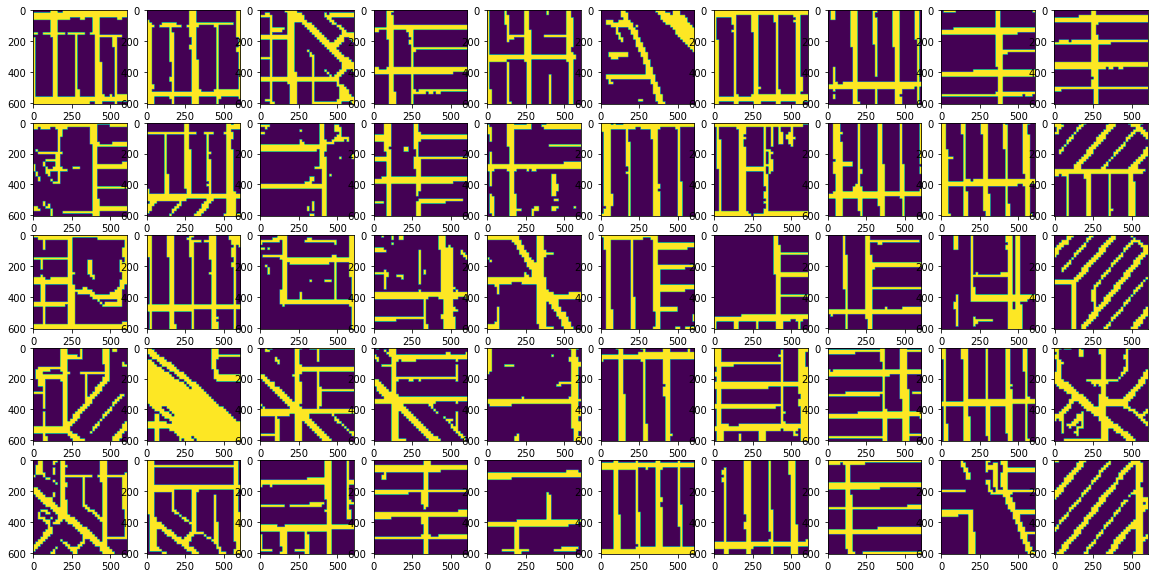

In [ ]:
plot_submission("./submissions/averaged_10_level5_submission.csv")